<img src="https://www.unir.net/wp-content/uploads/2019/11/Unir_2021_logo.svg" width="240" height="240" align="right"/>

<center><h1>Sistema inteligente para ayudar a detectar posibles reclamos (glosas) en las cuentas médicas previo al cobro, de una clínica en Colombia - Audimed</h1></center>
<center><h2>Trabajo Fin de Master<br>Máster Universitario en Análisis y Visualización de Datos Masivos / Visual Analytics and Big Data</h2></center>

<h3>Presentado por: Jacqueline Guzmán Rodriguez</h3>
<h4>Tipo de trabajo: Desarrollo Software <br>
Director: Juan Carlos Rincon Acuña <br>
Fecha: Junio/2024</h4>

<h3> <font color="#040078">Notebook de modelado de los datos</font></h3>
<h4>Gradient Boosting Classifier</h4>
<h5><font color="#C62400">Licencia del Notebook CC BY-NC-SA 4.0 DEED <a href="https://creativecommons.org/licenses/by-nc-sa/4.0/" target="_blank]">https://creativecommons.org/licenses/by-nc-sa/4.0/</a></font></h5/>

## Importación de librerias necesarias

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from time import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn_evaluation import plot
from sklearn.metrics import roc_curve, auc

## Carga de archivo con datos transformados claims.cvs
#### Se pueden descargar los datos de la plataforma kaggle en el siguiente link: 
##### https://www.kaggle.com/datasets/jacquelineguzman/claims-of-medical-billing/

In [2]:
# Read file CSV Download of https://www.kaggle.com/datasets/jacquelineguzman/claims-of-medical-billing/
file_cvs = "claims.csv"
# Create dataframe with information of file CSV
df = pd.read_csv(file_cvs, delimiter=',', encoding='utf-8')

## Tratamiento de datos previos a la aplicación del modelo de clasificación
##### Se define como variable objetivo la marca de si el registro tiene reclamación o no (CLAIM)

In [3]:
# Define colums target (CLAIM)
columns = df.columns
target = "CLAIM"
x_columns = columns.drop(target)

##### Se actualizan las variables para manejar tipos de datos a 32 bits, dado que usa menos recurso de memoria.

In [4]:
# Update datatype int64 to int32 and float64 to float32, because it is necessary to use less RAM
float_columns = ['QUANTITY_PRODUCT_SERVICE', 'SALES_PRICE', 'INVOICED_PRICE']
int_columns = columns.drop(float_columns)
df[float_columns]=df[float_columns].astype(np.float32)
df[int_columns]=df[int_columns].astype(int)

##### Para facilitar los calculos del algoritmo se normaliza la información de las variables de entrada para que manejen rangos numericos entre cero (0) y uno (1), esto se hace con la función MinMaxScaler

In [5]:
# Normalize data via MinMaxScaler function
scaler = MinMaxScaler()
df = scaler.fit_transform(df)
df = pd.DataFrame(df,columns=columns)

##### Se verifica la distribucción de la variable objetivo (CLAIM), donde se observa que es desbalanceda.

In [6]:
# Distribution of the target variable (CLAIM)
print(str(target)+':\n'+str(df[target].unique())+'\n')
print(df[target].value_counts())

CLAIM:
[0. 1.]

CLAIM
0.0    6104323
1.0        120
Name: count, dtype: int64


##### Se crean los dataframe de entrada (ValX) y salida (ValY) 

In [7]:
# Create dataframe with int variables (ValX) and target variable (ValY)
ValX = df.drop(columns=target)
ValY = df[target]

##### Se crean los dataframe de entrenamiento y validación, necesarios para el entrenamiento del modelo, se definió un 15% de los datos para los dataframe de validación

In [8]:
# Set training and validation data
X_train, X_validation, Y_train, Y_validation = train_test_split(ValX, ValY, test_size=0.15, random_state=1, shuffle=True)
X_train.shape, Y_train.shape, X_validation.shape, Y_validation.shape

((5188776, 53), (5188776,), (915667, 53), (915667,))

##### Para no trabajar con datos de entrenamiento desbalanceados, se aplica la técnica de sobremuestreo (over-sampling) sobre los datos de entrenamiento (X_train y Y_train)

In [9]:
# Resampling the minority class using SMOTE stategy (Over-sampling)
sm = SMOTE(sampling_strategy='minority', random_state=42)

In [10]:
# Fit the model to generate the data.
X_train, Y_train = sm.fit_resample(X_train, Y_train)

C:\Users\jefe.sistemas\AppData\Roaming\Python\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\jefe.sistemas\AppData\Roaming\Python\Python311\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [11]:
X_train.shape, Y_train.shape, X_validation.shape, Y_validation.shape

((10377344, 53), (10377344,), (915667, 53), (915667,))

## Creación del modelo
##### Se crea un modelo basado en boosting, especificamente un Gradient Boosting Classifier
##### Para verificar los hiperparametros, se hicienron procesos de prueba y error obteniendo los siguientes: 300 Iteraciones (max_iter=300), 3 ramas como máximo (max_depth=3), taza de aprendizaje 0.05 (learning_rate=0.05) y se le indico al modelo que la clases están desbalanceadas a través del parametro class_weight="balanced"

In [12]:
# Model Gradient Boosting Classifier
start_time = time()
HGBC_model = HistGradientBoostingClassifier(max_iter=300, max_depth=3,\
                                            class_weight="balanced", learning_rate=0.05)
HGBC_model.fit(X_train, Y_train)

HistGradientBoostingClassifier(class_weight='balanced', learning_rate=0.05,
                               max_depth=3, max_iter=300)

In [13]:
elapsed_time = time() - start_time
print("Elapsed time: %.10f seconds." % elapsed_time)

Elapsed time: 128.2352759838 seconds.


### Validación del modelo
##### Crear datase con los datos que predice el modelo (Y_predict), basado en los datos de validación X_validation

In [14]:
# Predict model, set results in Y_predict
Y_predict = HGBC_model.predict(X_validation)

##### Verificar el valor de la metrica de exactitud (accuracy)

In [15]:
# Calculate the accuracy of the model
print('Model accuracy score with 5 decision-trees : {0:0.4f}'.\
      format(accuracy_score(Y_validation, Y_predict)))

Model accuracy score with 5 decision-trees : 0.9990


##### Verificar la salida esperada con la salida de la predicción

In [16]:
# Example predicted value versus expected value
df_compare = pd.DataFrame({'Actual value': Y_validation, 'Predicted value': Y_predict})
df_compare.tail(10)

,Actual value,Predicted value
3141433,0.0,0.0
3895887,0.0,0.0
2199388,0.0,0.0
2010216,0.0,0.0
5153739,0.0,0.0
6054309,0.0,0.0
1411925,0.0,0.0
596122,0.0,0.0
5236999,0.0,0.0
4092770,0.0,0.0


##### Crear un dataframe resumen para verificar la cantidad de valores esperados clasificados en cada clase, versus los valores predichos

In [17]:
# Number of values ​​classified by each class, predicted versus expected values
sumary = pd.DataFrame({'Actual value': df_compare['Actual value'].value_counts(), 'Predicted value': df_compare['Predicted value'].value_counts()})
sumary.head()

,Actual value,Predicted value
0.0,915651,914747
1.0,16,920


##### Crear un diagrama de barras que permita observar el comportamiento de las clasificaciones de los valores esperados versus los valores predichos

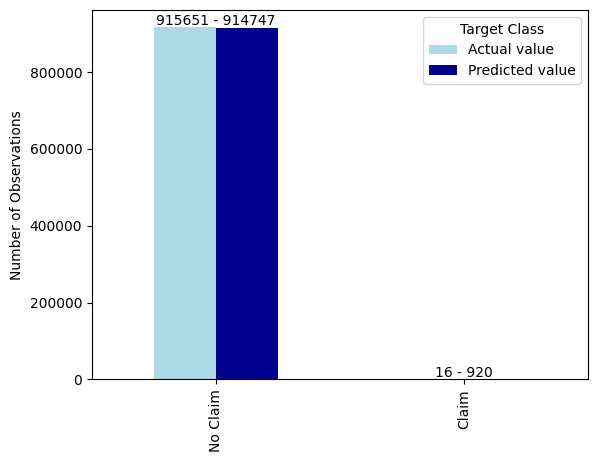

In [18]:
# Bar diagram with the behavior of the classification of predicted versus expected values
val_no_claim_valida=str(sumary['Actual value'][0])
val_no_claim_predict=str(sumary['Predicted value'][0])
val_no_claim=val_no_claim_valida+' - '+val_no_claim_predict
#print(val_no_claim)
val_claim_valida=str(sumary['Actual value'][1])
val_claim_predict=str(sumary['Predicted value'][1])
val_claim=val_claim_valida+' - '+val_claim_predict
#print(val_claim)
bar_colors = ['lightblue', 'darkblue']
sumary.plot.bar(color=bar_colors)
plt.xticks(range(2), ["No Claim","Claim"])
plt.text(0, sumary['Actual value'][0], val_no_claim, ha='center', va='bottom')
plt.text(1, sumary['Actual value'][1], val_claim, ha='center', va='bottom')
#plt.xlabel("Target Class")
plt.ylabel("Number of Observations")
plt.legend(title="Target Class")
plt.show()

##### Crear una matriz de confusión para observar el comportamiento de las clasificaciones de los valores predichos con respecto a los valores esperados

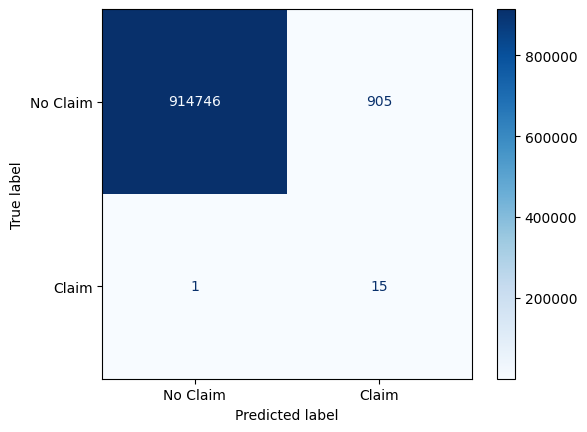

In [19]:
# Confusion matrix of model
confusion_matrix = confusion_matrix(df_compare['Actual value'], df_compare['Predicted value'])
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['No Claim', 'Claim'])
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

##### Ver los valores de las metricas de clasificación para observar si el modelo clasifica bien, en este caso se escoje la metrica de sensibilidad (recall), porque al estar tan desbalanceados los datos, es dificil encontrar un buen porcentaje de aciertos con la clase Claim, basados en metricas más generales como la exactitud (accuracy)

In [20]:
# Clasification report of model
print(classification_report(df_compare['Actual value'], df_compare['Predicted value']))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    915651
         1.0       0.02      0.94      0.03        16

    accuracy                           1.00    915667
   macro avg       0.51      0.97      0.52    915667
weighted avg       1.00      1.00      1.00    915667



##### A través de la curva ROC se observa el comportamiento de la sensibilidad (recall) del modelo y con el valor del área bajo la curva observamos si el modelo clasifica un gran porcentaje de casos de las dos clases

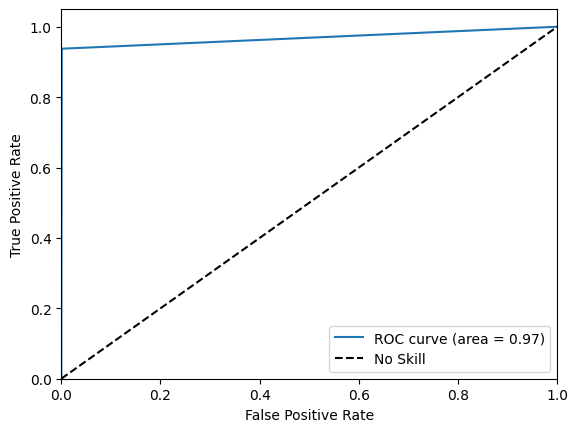

In [22]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(Y_validation, Y_predict) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()